In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)


In [3]:

def _vis_landscapes(
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # plt.figure
    plt.rc('font', size=28)
    if len(landscapes) == 2:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    elif len(landscapes) == 3:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    elif len(landscapes) == 4:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
    else:
        assert False

    fig.suptitle(title)
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'])

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx])
        axs[idx].set_xlabel('beta')
        axs[idx].set_ylabel('gamma')
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker == '*'
                markersize = 15
            
            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged solution")

            axs[idx].legend()

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))])
    # plt.legend()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close('all')

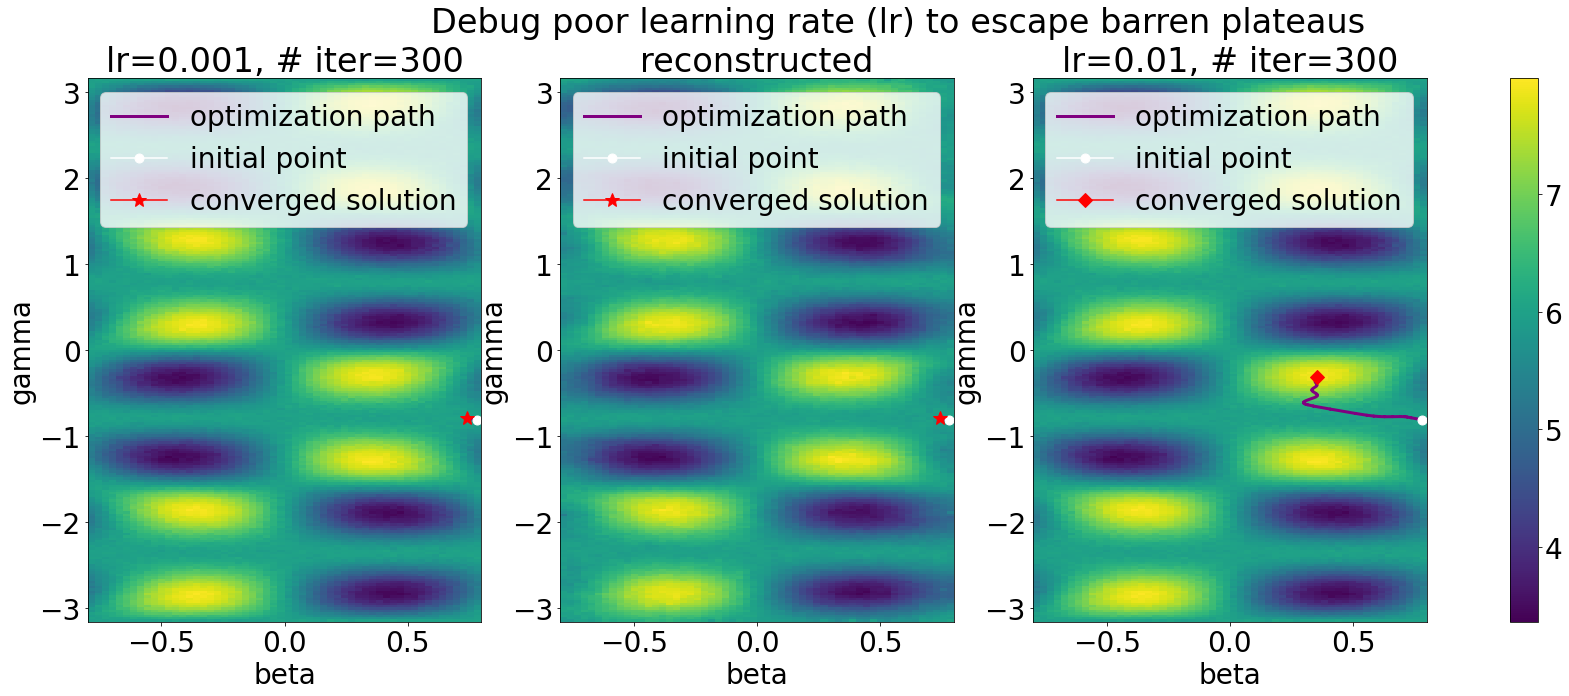

In [33]:
def vis_case1():

    # derive origin full landscapes
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()

    # derive optimization paths
    opt_data1 = np.load(
        "figs/opt_on_origin_landscape/2022-10-10_22:44:02/use_case_data.npz",
        allow_pickle=True)

    opt_data2 = np.load(
        "figs/opt_on_origin_landscape/2022-10-10_22:42:34/use_case_data.npz",
        allow_pickle=True
    )

    params_paths = [opt_data1['params_path'].tolist(), opt_data1['params_path'].tolist(), opt_data2['params_path']]

    _vis_landscapes(
        landscapes=[origin['unmitis'], recon['unmitis'], origin['unmitis']],
        labels=["lr=0.001, # iter=300", "reconstructed", "lr=0.01, # iter=300"],
        full_range=full_range,
        true_optima=None,
        title="Debug poor learning rate (lr) to escape barren plateaus",
        save_path="paper_figs/case1.png",
        params_paths=params_paths,
        converged_soln_markers=["*", "*", "D"]
        
    )
vis_case1()

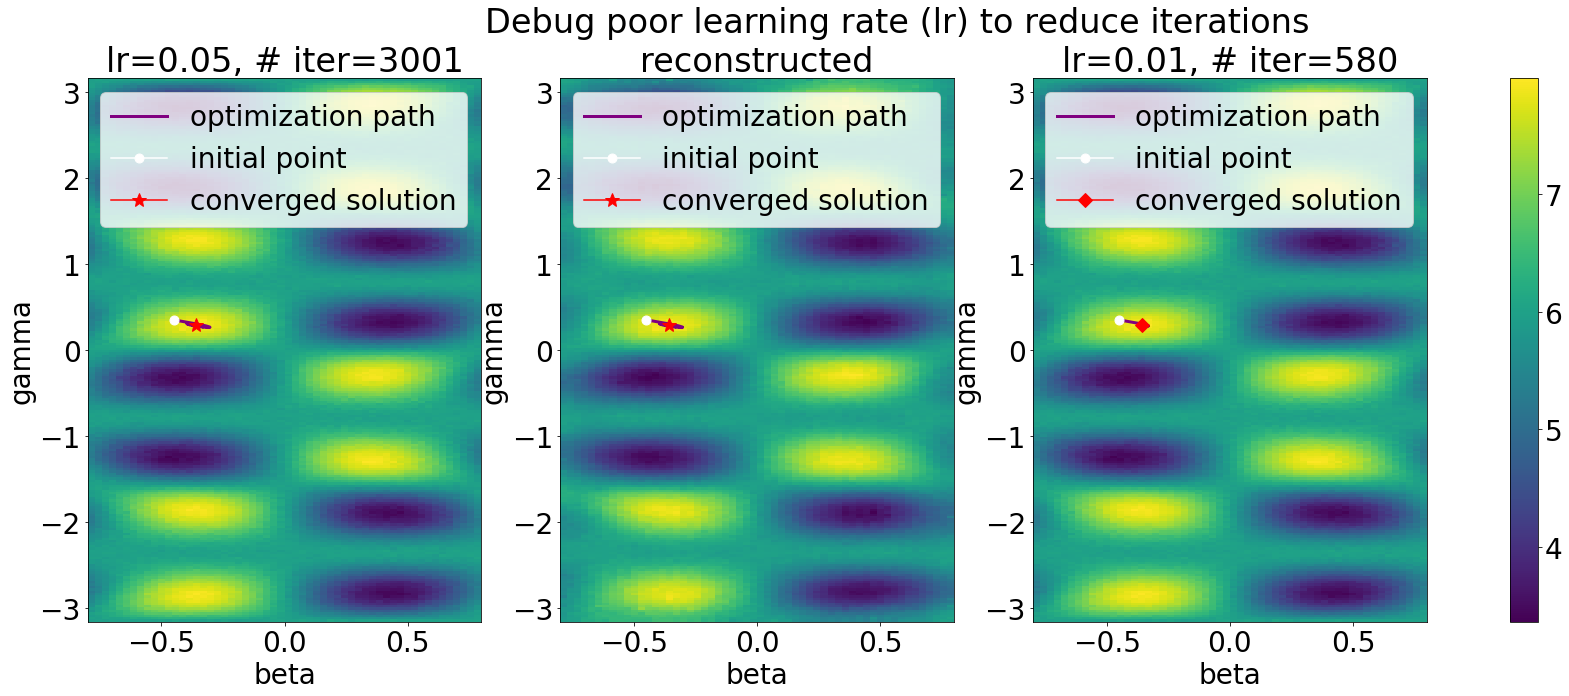

In [34]:
def vis_case2():

    # derive origin full landscapes
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()

    # derive optimization paths
    opt_data1 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_00:15:41/use_case_data.npz",
        allow_pickle=True)

    opt_data2 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_00:11:49/use_case_data.npz",
        allow_pickle=True
    )

    params_paths = [opt_data2['params_path'].tolist(), opt_data2['params_path'].tolist(), opt_data1['params_path']]

    _vis_landscapes(
        landscapes=[origin['unmitis'], recon['unmitis'], origin['unmitis']],
        labels=["lr=0.05, # iter=3001", "reconstructed", "lr=0.01, # iter=580"],
        full_range=full_range,
        true_optima=None,
        title="Debug poor learning rate (lr) to reduce iterations",
        save_path="paper_figs/case2.png",
        params_paths=params_paths,
        converged_soln_markers=["*", "*", "D"]
    )
vis_case2()

4059
4059
8597
0.0345358675623616
0.010419894882019217
0.012795744149123314
0.003925111398555986


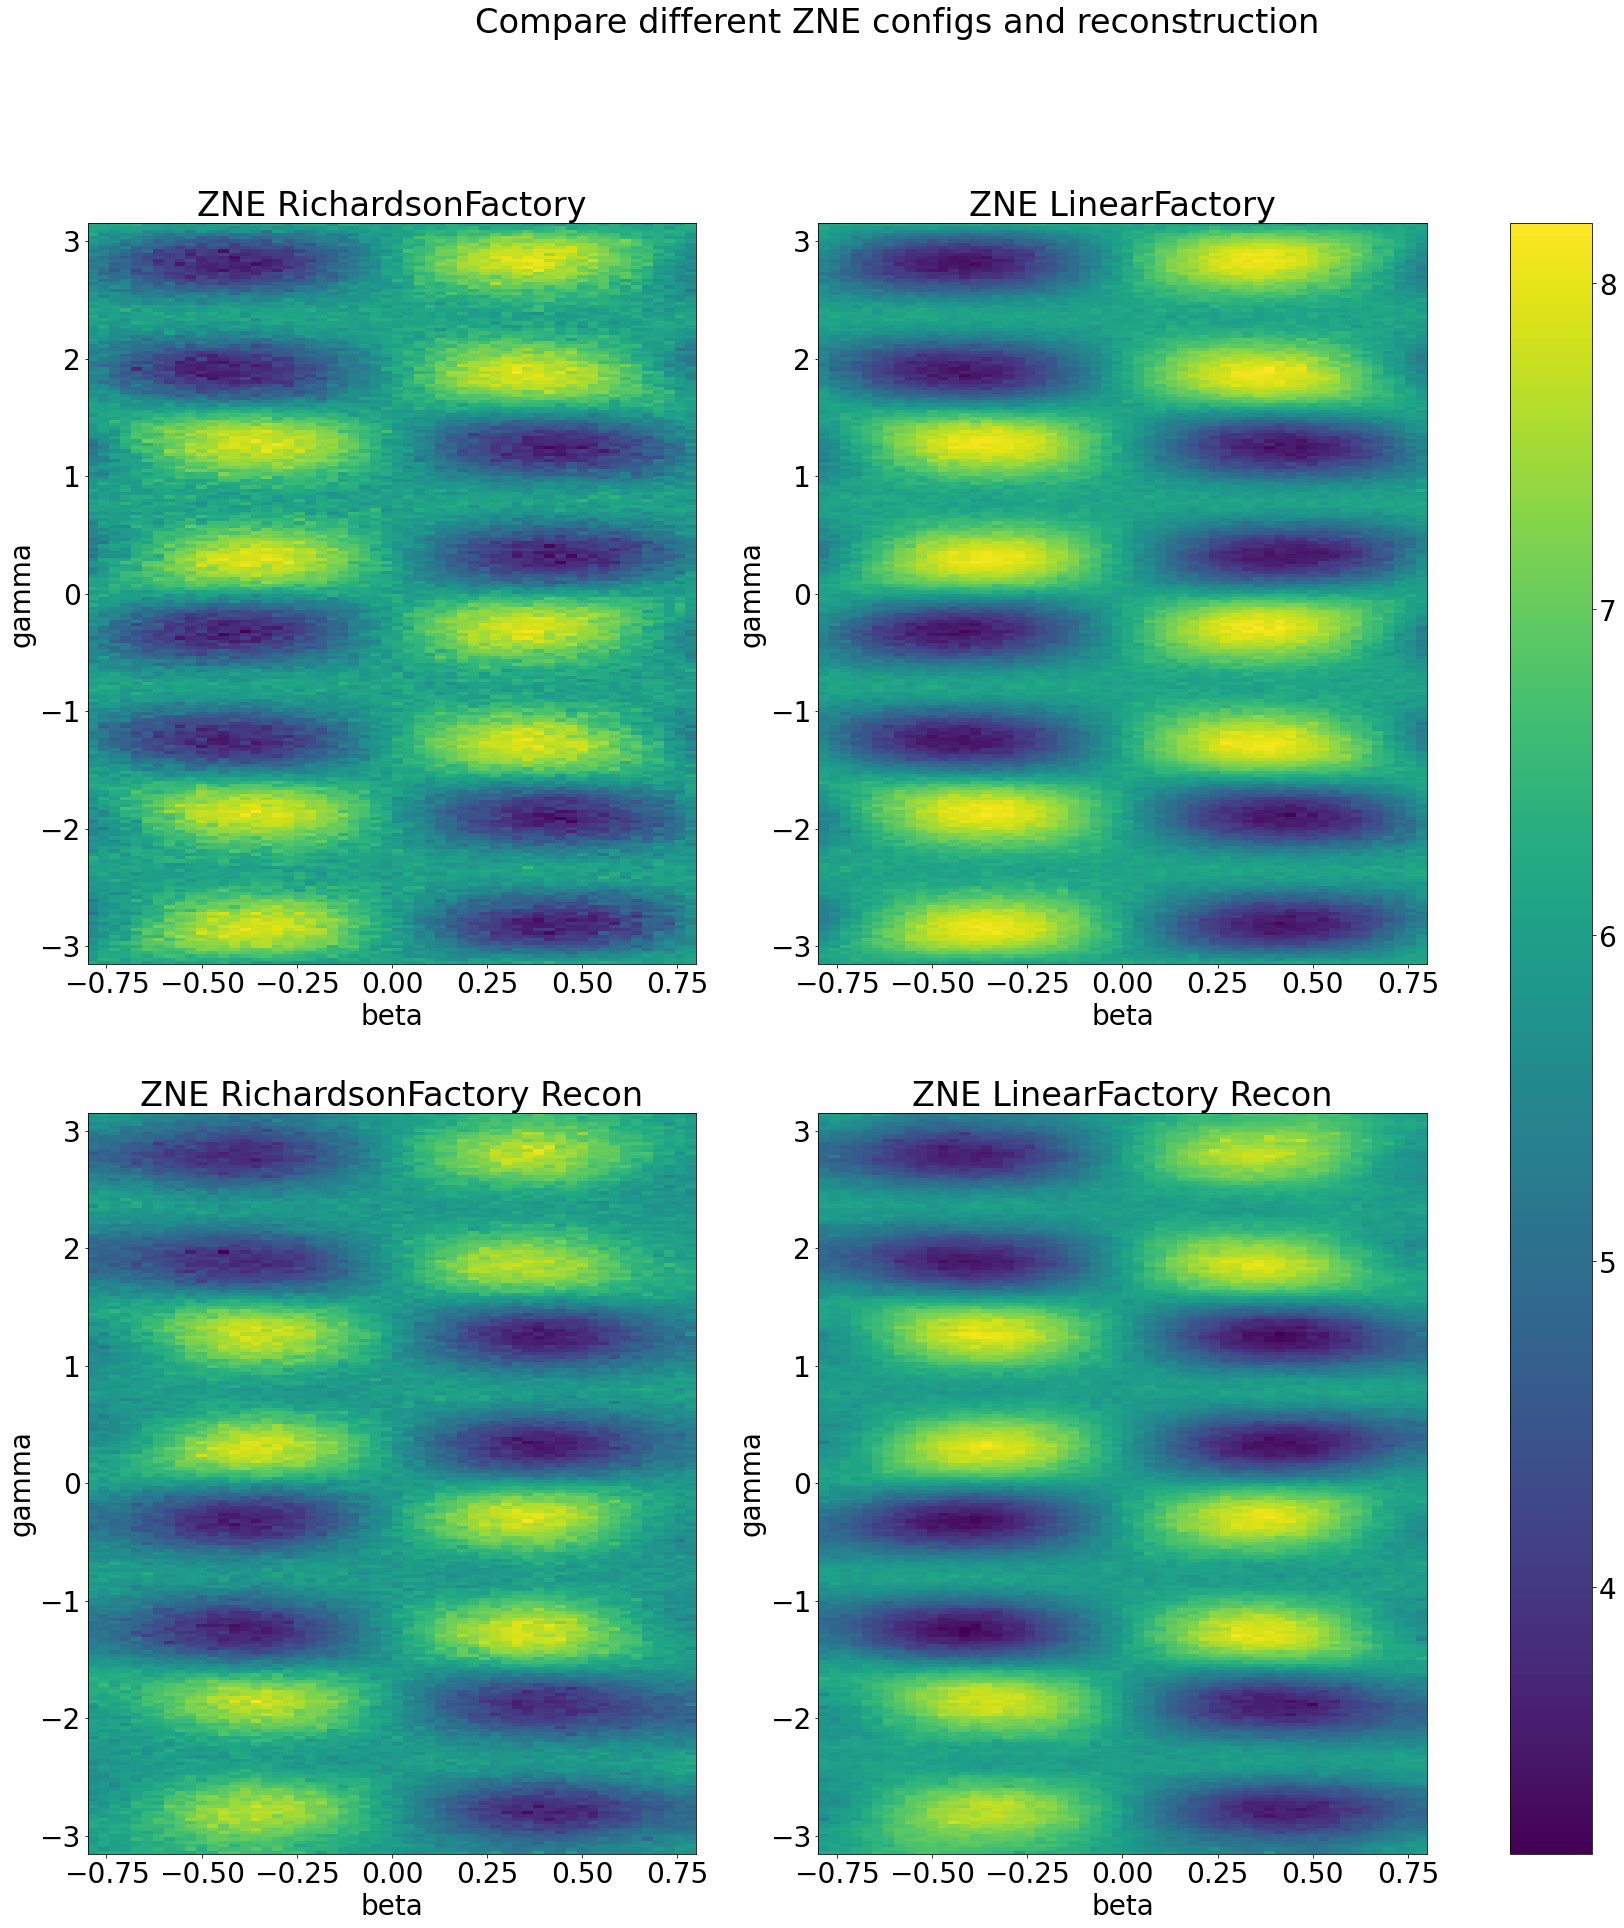

In [7]:
def vis_case_compare_mitigation_method():

    # derive origin full landscape
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()
    miti1 = origin['mitis']

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()
    miti1_recon = recon['mitis']

    data2_dir = "figs/gen_p1_landscape/2022-10-08_16:52:53/G40_nQ8_p1_depolar0.001_0.005_zneLinear"
    miti2 = np.load(f"{data2_dir}/data.npz", allow_pickle=True)['origin'].tolist()['mitis']
    recon2_path = f"{data2_dir}/2D_CS_recon_sf0.050.npz"
    miti2_recon = np.load(recon2_path, allow_pickle=True)['recon'].tolist()['mitis']

    # params_paths = [opt_data2['params_path'].tolist(), opt_data2['params_path'].tolist(), opt_data1['params_path']]

    # find some points where Richardson Factory is closer

    ideal = origin['ideals']

    # recon.
    # diff1 = ideal - miti1_recon   # Richardson factory
    # diff2 = ideal - miti2_recon   # linear factory
    
    # origin
    diff1 = ideal - miti1   # Richardson factory
    diff2 = ideal - miti2   # linear factory

    ids = np.abs(diff1) < np.abs(diff2)     # indices that Richardson is closer to ideal than linear

    print(np.sum(ids))
    print(np.sum(ids == True))
    print(np.sum(ids == False))
    
    print(np.var(diff1))
    print(np.var(diff2))

    print(np.var(np.abs(diff1)))
    print(np.var(np.abs(diff2)))

    _vis_landscapes(
        # landscapes=[origin['unmitis'], miti1, miti2, miti1_recon, miti2_recon],
        landscapes=[miti1, miti2, miti1_recon, miti2_recon],
        labels=["ZNE RichardsonFactory", "ZNE LinearFactory", "ZNE RichardsonFactory Recon", "ZNE LinearFactory Recon"],
        full_range=full_range,
        true_optima=None,
        title="Compare different ZNE configs and reconstruction",
        save_path="paper_figs/case3.png",
        params_paths=[None, None, None, None]
    )
vis_case_compare_mitigation_method()

[0.0010727892143963524, 0.0010727892143964635] [0.00042852398205883713, 0.00042852398206139064] [0 1]


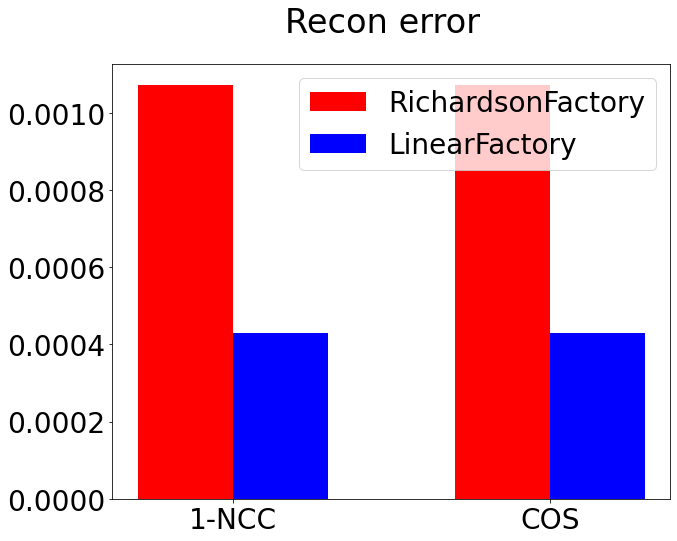

In [6]:
def vis_recon_error():
    # diff1 = {'L2-norm': 30.804969647723908, 'MSE': 0.2738246568786238, '1-NCC': 0.0010727892143963524, 'COS': 0.0010727892143964635}
    # diff2 = {'L2-norm': 19.65423771845724, 'MSE': 0.17470606077565495, '1-NCC': 0.00042852398205883713, 'COS': 0.00042852398206139064}
    
    diff1 = {'MSE': 0.2738246568786238, '1-NCC': 0.0010727892143963524, 'COS': 0.0010727892143964635}
    diff2 = {'MSE': 0.17470606077565495, '1-NCC': 0.00042852398205883713, 'COS': 0.00042852398206139064}
    
    diff1 = {'1-NCC': 0.0010727892143963524, 'COS': 0.0010727892143964635}
    diff2 = {'1-NCC': 0.00042852398205883713, 'COS': 0.00042852398206139064}

    plt.rc('font', size=28)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    axs = [axs]
    fig.suptitle("Recon error")

    xs = np.array(range(len(diff1.keys())))
    labels = list(diff1.keys())
    val1s = list(diff1.values())
    val2s = list(diff2.values())
    print(val1s, val2s, xs)
    bar_width = 0.3
    axs[0].bar(xs, val1s, width=bar_width, label='RichardsonFactory', color="r")
    axs[0].bar(xs+bar_width, val2s, width=bar_width, label='LinearFactory', color="b")
    # axs[0].xticks(xs + bar_width/2, labels)
    axs[0].set_xticks(xs + bar_width/2)
    axs[0].set_xticklabels(labels)
    plt.legend()
    # axs[0].set_title("var of beta")

    plt.show()
vis_recon_error()

In [60]:
from scipy.spatial.distance import (
    cosine
)
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
print(cosine(a, b))
print(np.linalg.norm(a - b))
print(np.sqrt(((a - b) ** 2).mean()))

0.0253681538029239
5.196152422706632
3.0


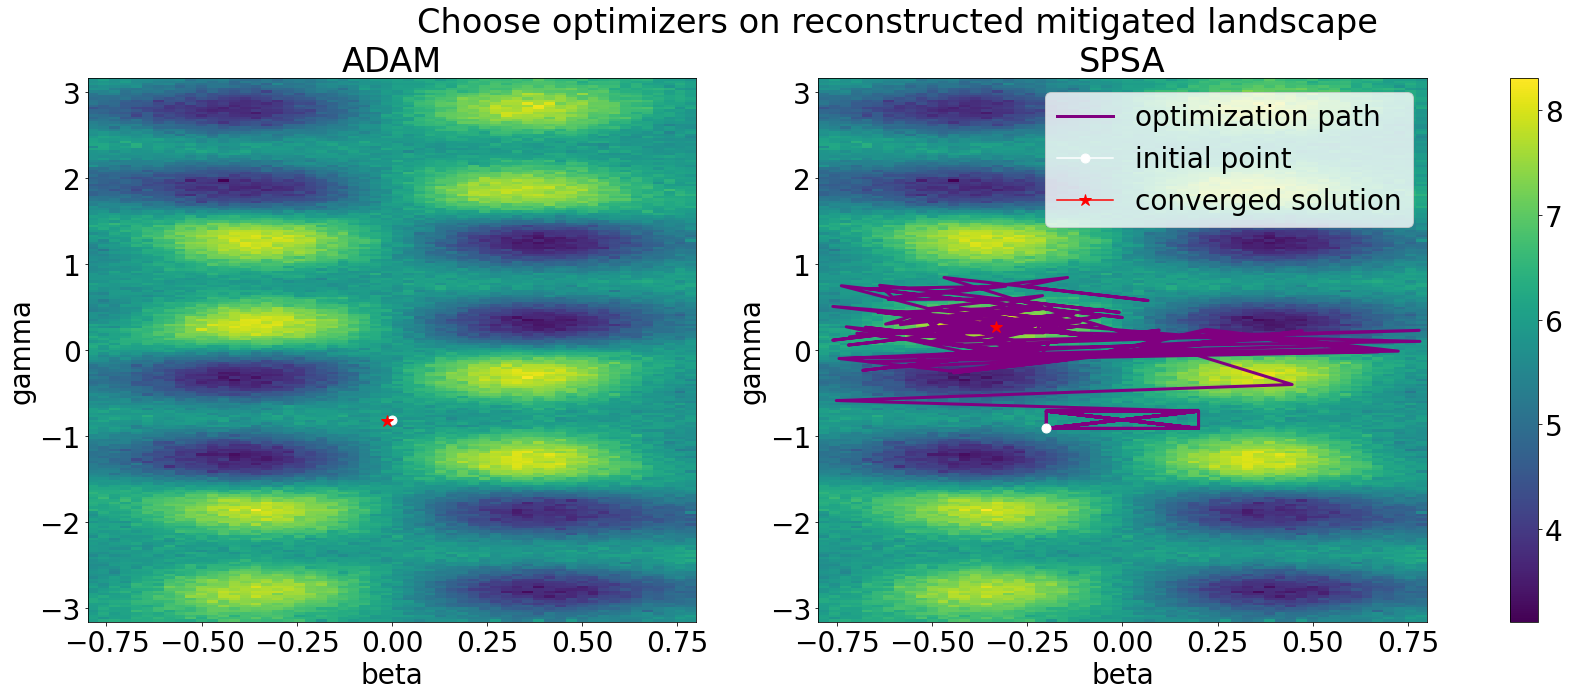

In [12]:
def vis_choose_optimizer():

    # derive origin full landscape
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    params1 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:52:27/data.npz", allow_pickle=True)['params_path']
    params2 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:55:28/data.npz", allow_pickle=True)['params_path']

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()


    
    
    _vis_landscapes(
        landscapes=[recon["mitis"], recon["mitis"]],
        labels=["ADAM", "SPSA"],
        full_range=full_range,
        true_optima=None,
        title="Choose optimizers on reconstructed mitigated landscape",
        save_path="paper_figs/case4.png",
        params_paths=[params1, params2]
    )
vis_choose_optimizer()

-8.2998046875 -8.428710937500064 0.12890625000006395
-8.3056640625 -8.612304687499979 0.3066406249999787
-8.3525390625 -8.330817914823644 0.021721147676355912
-8.416015625 -8.374481235295683 0.04153438970431722
-8.330078125 -8.314037995439449 0.01604012956055101
-8.2919921875 -8.322697391571902 0.030705204071901804
-8.1259765625 -8.403532095071998 0.2775555325719985
-8.201171875 -8.392578124999837 0.19140624999983658
-8.2333984375 -8.343836307770928 0.11043787027092833
-8.1103515625 -8.361328124999943 0.25097656249994316
-8.21875 -8.363358930649913 0.14460893064991254
-8.15234375 -8.319335937500126 0.16699218750012612
-8.15625 -8.515698795966433 0.35944879596643275
-8.1337890625 -8.35123895262202 0.21744989012202076
-8.0634765625 -8.315429687500053 0.2519531250000533
-8.216796875 -8.315359955016147 0.098563080016147
-8.111328125 -8.326171874999986 0.2148437499999858
-8.23828125 -8.36402514641549 0.12574389641548933
-8.1875 -8.377441203370275 0.18994120337027454
-8.416015625 -8.35216481

/var/folders/s6/0_r3sfzd5t1786h_d_ct3wf40000gn/T/ipykernel_32406/319321806.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies = np.array(energies, dtype=float)


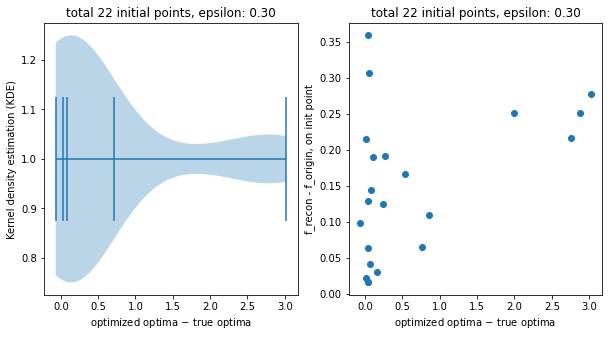

In [59]:
from distutils.log import error


def vis_find_init_pts_by_recon():
    sf = 0.050
    p = 2
    data_dir = "figs/gen_p2_landscape/2022-10-01_16:15:33/G41_nQ8_p2_depolar0.001_0.005"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_ranges: list = data['full_ranges'].tolist()
    # bounds = data['bounds'].tolist()
    # n_pts_per_unit = data['n_pts_per_unit']
    # C_opt = data['C_opt']

    recon_dir = "figs/recon_p2_landscape/2022-10-01_19:50:01" # 0.05
    recon = np.load(f"{recon_dir}/recon_p2_landscape_sf{sf:.3f}.npz")['arr_0']

    # ====================== vis ======================
    init_data = np.load("figs/find_init_pts_by_recon/2022-10-13_14:30:54/G41_nQ8_p2.npz", allow_pickle=True) # eps = 0.3
    # init_data = np.load("figs/find_init_pts_by_recon/2022-10-13_13:34:25/G41_nQ8_p2.npz", allow_pickle=True) # eps = 0.4
    # init_data = np.load("figs/find_init_pts_by_recon/2022-10-20_12:43:52/G41_nQ8_p2.npz", allow_pickle=True) # eps = 0.5
    ids = init_data['ids']
    # energies = init_data['min_eneries']
    energies = init_data['min_energies']
    min_recon = init_data['min_recon']
    C_opt = init_data['C_opt']
    eps = init_data['eps']

    # print(ids)
    # print(energies)
    energies = np.array(energies, dtype=float)
    # print(energies)

    # recon. error on the initial points
    recon = -recon
    origin = -origin['unmitis']
    # origin = -origin['ideals']
    recon_errors = []
    for idx in ids: # idx: tuples
        # print(recon[idx[0], idx[1], idx[2], idx[3]])
        # print(recon[tuple(idx)])
        # print(idx, recon[idx[0], idx[1], idx[2], idx[3]])
        # continue

        init_recon = recon[tuple(idx)]
        init_origin = origin[tuple(idx)]
        error = init_recon - init_origin
        # error = np.abs(init_recon - init_origin)
        error = np.abs(error)
        print(init_origin, init_recon, error)
        recon_errors.append(error)

    # ==================== vis =====================
    import matplotlib.patches as mpatches
    # diff = C_opt - energies
    diff = energies - C_opt
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs.reshape(-1)
    # plt.hist(diff, bins=50)
    # https://blog.csdn.net/mighty13/article/details/117405722
    rst = axs[0].violinplot(diff, quantiles=[0.25, 0.5, 0.75], vert=False)

    # color = rst['bodies'][0].get_facecolor().flatten()
    # patch = mpatches.Patch(color=color, label="")
    axs[0].set_xlabel("optimized optima $-$ true optima")
    # axs.set_ylabel("# initial points")
    axs[0].set_ylabel("Kernel density estimation (KDE)")
    # plt.legend()
    axs[0].set_title(f"total {len(ids)} initial points, epsilon: {eps:.2f}")
    print(rst)
    print(rst['cquantiles'])

    # ============ correlation value ==========
    from scipy.stats import pearsonr, spearmanr
    r_p, p_p = pearsonr(diff, recon_errors)
    r_s, p_s = spearmanr(diff, recon_errors)
    print("")
    
    print(f"Pearson : r={r_p:+.5f}\t p={p_p:.5f}\n"
          f"Spearman: r={r_s:+.5f}\t p={p_s:.5f}")
    
    axs[1].scatter(diff, recon_errors)

    # color = rst['bodies'][0].get_facecolor().flatten()
    # patch = mpatches.Patch(color=color, label="")
    axs[1].set_xlabel("optimized optima $-$ true optima")
    # axs.set_ylabel("# initial points")
    axs[1].set_ylabel("f_recon - f_origin, on init point")
    # plt.legend()
    axs[1].set_title(f"total {len(ids)} initial points, epsilon: {eps:.2f}")


    # quantiles

vis_find_init_pts_by_recon()

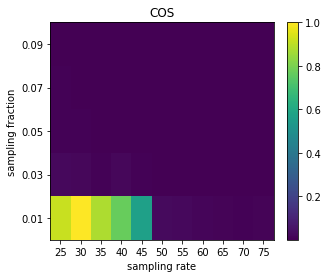

In [23]:
def heatmap_sf_sr_recon_error(sf_range, sr_range, errors):
    fig = plt.figure(figsize=[5, 4])
    # plt.plot()
    ax = plt.axes()
    # plt.plot(beta_opt, gamma_opt, "ro")

    X, Y = np.meshgrid(sr_range, sf_range, indexing='ij')
    Z = errors.reshape(len(sr_range), len(sf_range))

    c = ax.pcolormesh(X, Y, Z) # , cmap='viridis', vmin=z_min, vmax=z_max)
    # ax.axis([X.min(), X.max(), Y.min(), Y.max()])

    ax.set_xlabel("sampling rate")
    ax.set_xticks(sr_range)
    ax.set_ylabel("sampling fraction")
    ax.set_yticks(sf_range)
    ax.set_title("COS")
    # ax.plot(beta_opt, gamma_opt, "ro")
    fig.colorbar(c, ax=ax)
    # fig.savefig(figpath)
    plt.show()
    
mse = [2.118698600320954, 0.4264235441805948, 0.23822630844099071, 0.20689894933684855, 0.08179201689773634, 2.2506459599867297, 0.4361775598188958, 0.28659993733247136, 0.08744856847992419, 0.0732864746349093, 2.167304785566338, 0.2582870914352997, 0.07478826860249567, 0.08504810899867897, 0.027660263129608294, 2.0826489226719773, 0.4974349673297324, 0.10023255899534426, 0.043216215279435435, 0.012896733064577717, 1.890956325776356, 0.245688530621947, 0.1642245597373079, 0.04092778340638934, 0.009768291372807237, 0.6236907857945042, 0.07233869787634145, 0.04904438203387639, 0.006495148753355689, 0.004773276637086853, 0.45381613699741424, 0.09717807985892747, 0.020318993450127804, 0.0048653611344645215, 0.005854854988494881, 0.4079406685982311, 0.05752508146084986, 0.03293372173454906, 0.005337024286452811, 0.0016303156632120727, 0.32382769815856427, 0.04637524040669229, 0.007910584000797893, 0.011292997260871044, 0.0020378982544017655, 0.2728995121818533, 0.034334197749544375, 0.0279716691639176, 0.013906723654300636, 0.001582039421033094, 0.2951727273794584, 0.024794543470055355, 0.004180796621427102, 0.009449785715426139, 0.0011158319481410295]
cos = [0.9170881306593054, 0.020395174146597972, 0.00566981610523154, 0.0039384215167377334, 0.0007302953545714752, 1.0004203497002622, 0.0188219007392203, 0.007393527964160818, 0.0008502044459147706, 0.0005899466741239312, 0.8769843605026652, 0.006205772549262689, 0.0005508984920948867, 0.0007414948727852977, 7.253485673319737e-05, 0.7693052304633172, 0.01950434449772509, 0.001064726690196749, 0.0002024321084277414, 1.8883842521799643e-05, 0.5646786756984006, 0.006642873884647016, 0.0029412072261973954, 0.00018737105799071507, 1.0644817274751972e-05, 0.027019925328360506, 0.0005010397101369302, 0.00026940280691556406, 4.361747626302481e-06, 2.5351871332235376e-06, 0.021951737749359213, 0.0008852483031792646, 3.9699370302459513e-05, 2.5529419176439916e-06, 3.841655672132127e-06, 0.012003482167032176, 0.00033436962588717645, 0.00011804230235890056, 3.15399044503728e-06, 2.913723184949646e-07, 0.00905803211426015, 0.00022103601155998298, 6.564199006353633e-06, 1.4181103266008854e-05, 4.6520245389203296e-07, 0.005834684113153243, 0.0001240059951487238, 8.686624768983187e-05, 2.1601343854538158e-05, 2.750607249746295e-07, 0.008060298714766545, 5.8996589237358954e-05, 1.900175701008422e-06, 1.0013390652097165e-05, 1.3908894402892003e-07]

sr_range = range(25, 76, 5)
sf_range = np.arange(0.01, 0.11, 0.02)
heatmap_sf_sr_recon_error(sf_range, sr_range, np.array(cos))
# heatmap_sf_sr_recon_error(sf_range, sr_range, np.array(mse))
    

(3, 2, 5)
[[[0.50393911 0.10187542 0.03052103 0.01210027 0.0078797 ]
  [0.81640159 0.10280057 0.03124683 0.01365593 0.00904611]]

 [[0.51113575 0.12415766 0.06143918 0.04770089 0.01681764]
  [0.51061625 0.12448309 0.06159363 0.04778265 0.01681811]]

 [[1.88213325 0.10812473 0.05626311 0.04095222 0.03090471]
  [1.87434466 0.11086259 0.05872781 0.04143577 0.03140312]]]


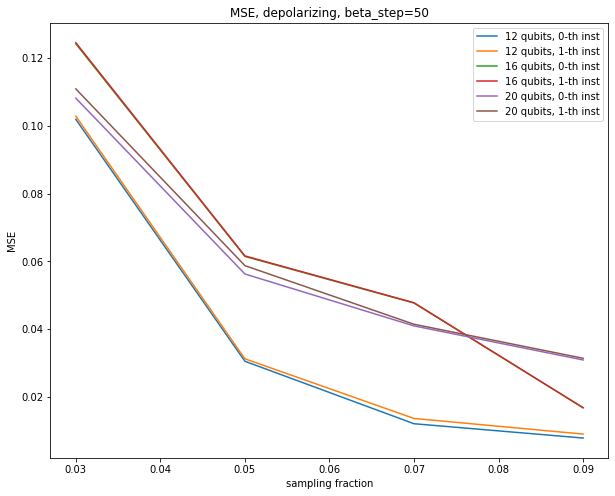

In [98]:
def vis_recon_error_p1(nq_range, inst_range, sf_range, errors, start=1):
    errors = errors.reshape(len(nq_range), len(inst_range), len(sf_range))
    print(errors.shape)
    print(errors)
    fig = plt.figure(figsize=[10, 8])
    # plt.plot()
    ax = plt.axes()
    for i in range(len(nq_range)):
        for j in range(len(inst_range)):
            # print(sf_range[2:])
            ax.plot(sf_range[start:], errors[i,j,start:], label=f"{nq_range[i]} qubits, {inst_range[j]}-th inst")
    # plt.plot(beta_opt, gamma_opt, "ro")

    # X, Y = np.meshgrid(sr_range, sf_range, indexing='ij')
    # Z = errors.reshape(len(sr_range), len(sf_range))

    # c = ax.pcolormesh(X, Y, Z) # , cmap='viridis', vmin=z_min, vmax=z_max)
    # ax.axis([X.min(), X.max(), Y.min(), Y.max()])

    ax.set_xlabel("sampling fraction")
    # ax.set_xticks(sr_range)
    ax.set_ylabel("MSE")
    # ax.set_yticks(sf_range)
    ax.set_title("MSE, depolarizing, beta_step=50")
    plt.legend()
    # ax.plot(beta_opt, gamma_opt, "ro")
    # fig.colorbar(c, ax=ax)
    # fig.savefig(figpath)
    plt.show()
    return errors

# depolarizing 0.001, 0.005
# mse = [0.5294567889697064, 0.10504512962369626, 0.0313981299420259, 0.012503321574744162, 0.008140374429632507, 0.8424334405179074, 0.10568723568802518, 0.03212506658687189, 0.014080103905186459, 0.009296142398008756, 0.526865075200324, 0.12747919612932213, 0.06309042154958099, 0.049028926963782395, 0.017344741404916143, 0.5292877712080678, 0.12807155118871388, 0.06338557278944737, 0.04927365907019386, 0.01742941715973452, 1.9361662554992944, 0.11117192831199525, 0.05794935815783304, 0.042218665732938074, 0.031913622196141994, 1.9274262480485385, 0.11380618083255489, 0.06048147435362607, 0.042544439403038134, 0.032231339880888894]
# cos = [0.03345611343649668, 0.001882758932071349, 0.00018351884817768838, 3.2312424903535586e-05, 1.3707400878582021e-05, 0.1189645214978915, 0.00180777477491334, 0.0001907390154839428, 4.040555030127013e-05, 1.7545841520250072e-05, 0.023844061448096587, 0.002032726517411043, 0.0004999788199564481, 0.00030430659574010033, 3.7662019811590675e-05, 0.02382890847269281, 0.0020325601979672703, 0.0004999731174260003, 0.0003044908765591492, 3.767714656655041e-05, 0.3036874338519604, 0.0008274828744364582, 0.0002466740593143335, 0.0001358167458470616, 7.858596328635947e-05, 0.29930637856623044, 0.0008437189310439575, 0.0002633779178375928, 0.0001353103607633077, 7.849847216112593e-05]

# depolarizing 0.003, 0.007
mse =  [0.5039391145820539, 0.10187541579824788, 0.030521028927380053, 0.012100274958501474, 0.007879699198447391, 0.8164015928099697, 0.10280057365192978, 0.031246832290654097, 0.013655930917672875, 0.00904611410285615, 0.5111357466189159, 0.12415765730594497, 0.06143917804136556, 0.047700887403396286, 0.016817643074515512, 0.5106162502837763, 0.12448309263267172, 0.06159363454853711, 0.047782653207815724, 0.016818108440983092, 1.8821332493158773, 0.10812472566677976, 0.05626310971617496, 0.040952219495018434, 0.030904712822065413, 1.8743446567979802, 0.11086259352599241, 0.05872780804047352, 0.04143577374538176, 0.031403123343349756]
cos =  [0.03136409094172088, 0.0018815084299171891, 0.00018399240948696605, 3.213134121327066e-05, 1.364762014444132e-05, 0.11782864549589178, 0.0018098338121567137, 0.00019087352646751654, 4.0206323897673535e-05, 1.7577098521237566e-05, 0.02374738664478715, 0.002033384390250359, 0.000500005455133401, 0.00030376060436587693, 3.733602140165715e-05, 0.023632971680983994, 0.0020339993226150543, 0.0005000360258804459, 0.00030330285893775955, 3.7151272810787006e-05, 0.30499961591915303, 0.0008297448762913939, 0.00024676532028444775, 0.00013542860375459487, 7.80946002396643e-05, 0.2968800883830971, 0.0008426220675257223, 0.00026143955952540043, 0.00013512567448970003, 7.84428741792409e-05]

nq_range = [12, 16, 20]
inst_range = [0, 1]
sf_range = np.arange(0.01, 0.11, 0.02)
errors_noisy = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(mse))
# errors_noisy = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(cos))

    

(4, 3, 5)
[[[0.55657666 0.1343777  0.06651262 0.05173367 0.01835361]
  [0.55657666 0.1343777  0.06651262 0.05173367 0.01835361]
  [0.68282556 0.13436983 0.06771727 0.05290551 0.0201816 ]]

 [[2.02922718 0.1164266  0.06080085 0.04434118 0.03348434]
  [2.02817165 0.11964962 0.06381787 0.04465773 0.03387594]
  [2.02922718 0.1164266  0.06080085 0.04434118 0.03348434]]

 [[0.78117256 0.17756208 0.10550643 0.06928139 0.04292072]
  [1.08962854 0.17873801 0.10537584 0.06966476 0.04316006]
  [0.46352344 0.14353503 0.08427835 0.06669484 0.04147055]]

 [[0.88665984 0.1725787  0.0645507  0.01047823 0.00617623]
  [1.10684714 0.17071471 0.06657053 0.01097883 0.00721582]
  [1.10684714 0.17071471 0.06657053 0.01097883 0.00721582]]]


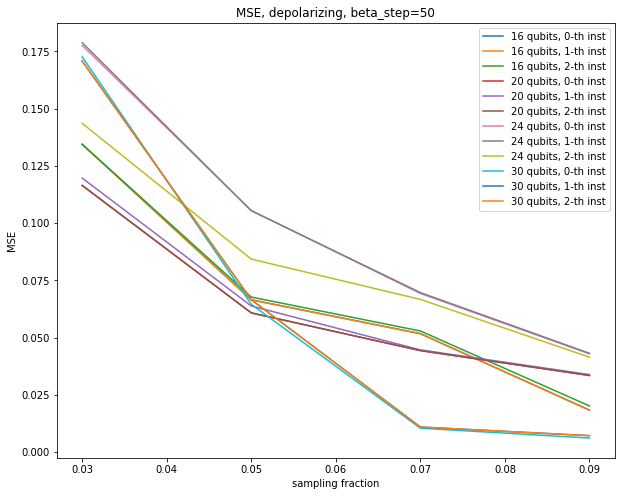

In [94]:
# ideal, recon error

mse = [0.5565766581873556, 0.13437769973619176, 0.0665126187210659, 0.05173366713103397, 0.018353605365084492, 0.5565766581873564, 0.13437769973619085, 0.0665126187210705, 0.05173366713103232, 0.018353605365095765, 0.682825558610413, 0.13436982692393828, 0.06771727263453953, 0.05290551293891448, 0.020181597010536727, 2.029227178397665, 0.11642660067801282, 0.060800852770935145, 0.044341175517035925, 0.03348434250303546, 2.0281716542777444, 0.1196496159743286, 0.06381786828961503, 0.04465772552423436, 0.0338759429431382, 2.0292271783976656, 0.11642660067801273, 0.060800852770934756, 0.04434117551703168, 0.03348434250302957, 0.7811725565489757, 0.17756207745900035, 0.10550643279176339, 0.06928139310076305, 0.04292071947529103, 1.0896285401626504, 0.17873801113689375, 0.10537584283381209, 0.06966475606687052, 0.043160056088815305, 0.4635234362873778, 0.14353502668475, 0.08427835200777564, 0.06669484054414562, 0.0414705455723753, 0.8866598378767956, 0.1725787043917337, 0.0645506992899331, 0.010478228635834533, 0.006176225731408726, 1.1068471367355863, 0.17071470648289172, 0.06657052809749948, 0.010978833158495228, 0.007215821376888723, 1.1068471367355976, 0.1707147064829075, 0.06657052809749567, 0.010978833158501159, 0.007215821376886939]
cos = [0.02393922161288986, 0.002031606312861367, 0.0004998125049687774, 0.00030476000060497555, 3.79319452308291e-05, 0.02393922161288975, 0.002031606312861478, 0.0004998125049689994, 0.0003047600006051976, 3.7931945231051145e-05, 0.036562052853848614, 0.0019962271792863806, 0.0005100434114092556, 0.00031427900251856933, 4.5381234023311734e-05, 0.30298364798410826, 0.0008244283731778657, 0.00024676555660385624, 0.00013625217729096306, 7.868483674555726e-05, 0.30174074270188933, 0.0008457772434531385, 0.00026585457433536686, 0.0001351682739886284, 7.861509642415054e-05, 0.3029836479841084, 0.0008244283731778657, 0.0002467655566040783, 0.00013625217729107408, 7.868483674544624e-05, 0.02138526815999564, 0.0013933410189659323, 0.0005435088913930963, 0.00023855821507523522, 9.208463972287806e-05, 0.04468944716383838, 0.0013721218090904097, 0.0005333604725971108, 0.00023836158472689828, 9.200612198623226e-05, 0.006355165400067975, 0.0009692026592464931, 0.0003517273108397667, 0.00022428604096047522, 8.678210358059602e-05, 0.015555523348037337, 0.0007856194744289002, 0.0001262640961463557, 3.397591558429447e-06, 1.2065216363765785e-06, 0.026571657214737088, 0.0007513541621994024, 0.00013321254320652898, 3.715799604009362e-06, 1.6273890477425113e-06, 0.026571657214737865, 0.0007513541621996245, 0.00013321254320652898, 3.7157996037873176e-06, 1.627389047631489e-06]
nq_range = [16, 20, 24, 30]
inst_range = [0, 1, 2]
sf_range = np.arange(0.01, 0.11, 0.02)
errors_ideal = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(mse))
# errors_ideal = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(cos))
    

(4, 3, 5)
(3, 2, 5)


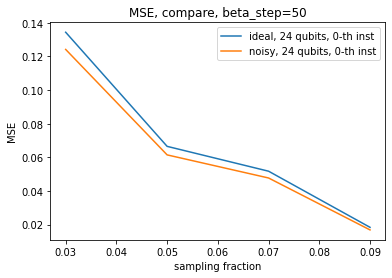

IndexError: list index out of range

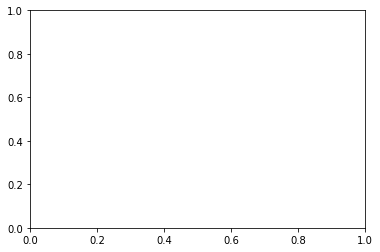

In [97]:
def compare_p1_recon_ideal_and_noisy(sf_range, es_ideals, es_noisys, start=1):
    seeds = [0, 1]
    nQs = [16, 20] # intersect of ideal and noisy data
    print(es_ideals.shape)
    print(es_noisys.shape)

    for i in range(len(nQs)):
        for j in range(len(seeds)):
            es_ideal = es_ideals[i, j, start:] # 16, 20, 24, 30
            es_noisy = es_noisys[i + 1, j, start:] # 12, 16, 20

            fig = plt.figure(figsize=[6, 4])
            ax = plt.axes()
            ax.plot(sf_range[start:], es_ideal, label=f"ideal, {nq_range[i]} qubits, {inst_range[j]}-th inst")
            ax.plot(sf_range[start:], es_noisy, label=f"noisy, {nq_range[i]} qubits, {inst_range[j]}-th inst")
            ax.set_xlabel("sampling fraction")
            ax.set_ylabel("MSE")
            ax.set_title("MSE, compare, beta_step=50")
            plt.legend()
            plt.show()
        
    return
compare_p1_recon_ideal_and_noisy(sf_range, es_ideals=errors_ideal, es_noisys=errors_noisy)

(1, 1, 5)
[[[0.18824535 0.07806253 0.03269122 0.01754122 0.01065391]]]


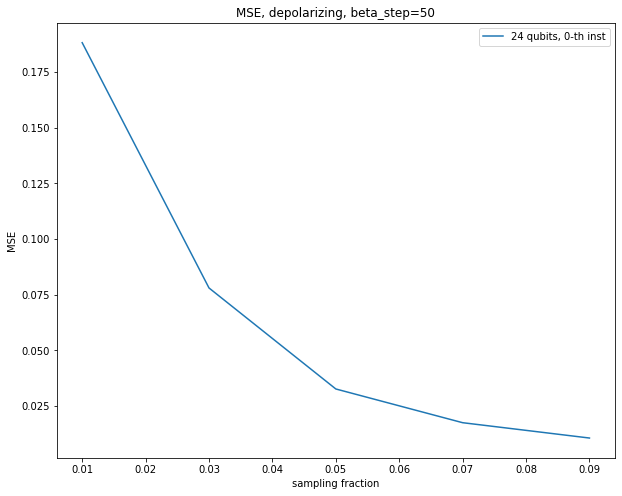

In [101]:
mse =  [2.5098071285543138, 1.6552018198271319, 1.093384378156003, 0.8044046488875147, 0.6273614828069227]
cos =  [0.18824535005095422, 0.07806253240573047, 0.03269121889389315, 0.017541222786266242, 0.010653914431462241]

nq_range = [24]
inst_range = [0]
sf_range = np.arange(0.01, 0.11, 0.02)
# errors_p2 = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(mse), 0)
errors_p2 = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(cos), 0)

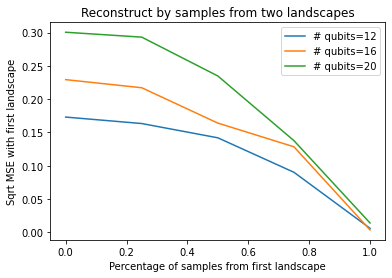

In [16]:
def cs_by_distributed_landscapes():
    data_paths = [
        "figs/recon_distributed_landscape/2022-11-05_12:51:53_OK/distributed_LS_errors-n=12-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz",
        "figs/recon_distributed_landscape/2022-11-05_12:53:56_OK/distributed_LS_errors-n=16-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz",
        "figs/recon_distributed_landscape/2022-11-05_12:55:51_OK/distributed_LS_errors-n=20-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz"
    ]
    
    datas = []
    for data_dir in data_paths:
        datas.append(np.load(data_dir, allow_pickle=True))

    nqs = [12, 16, 20]

    fig = plt.figure(figsize=[6, 4])
    ax = plt.axes()
    # for nq in nqs:
    for nq, data in zip(nqs, datas):
        errors1 = data['errors1']
        ratios = data['ratios']
        ax.plot(ratios, errors1, label=f"# qubits={nq}")

    # ax.plot(sf_range[start:], es_noisy, label=f"noisy, {nq_range[i]} qubits, {inst_range[j]}-th inst")
    ax.set_xlabel("Percentage of samples from first landscape")
    ax.set_ylabel("Sqrt MSE with first landscape")
    ax.set_title("Reconstruct by samples from two landscapes")
    plt.legend()
    fig.savefig("paper_figs/recon_error_by_distributed_LS.svg", bbox_inches='tight')
    plt.show()

    return
cs_by_distributed_landscapes()